#### ライブラリ

In [105]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

#### 前処理

In [106]:
"""
UNet-WDで使用するものは、Bidet, Kitchenfaucet, Shower, Washbasinぽい
"""

path = R"C:\Users\Ca_on\Work\001_DSmentor\002_institute_of_infomation_seculity\EL-WaterDemandTS\data_raw"

# 家全体の総水使用量
whole_house = pd.read_csv(path + R"\feed_WholeHouse.MYD.csv", header=None, delimiter=" ")

# 各水器具の水使用量
toilet = pd.read_csv(path + R"\feed.Toilet.csv", delimiter=" ")
bidet = pd.read_csv(path + R"\feed_Bidet.MYD.csv", )
dishwasher = pd.read_csv(path + R"\feed_Dishwasher30.MYD.csv", delimiter=" ")
kitchen_faucet = pd.read_csv(path + R"\feed_Kitchenfaucet.MYD.csv", )
shower = pd.read_csv(path + R"\feed_Shower.MYD.csv", header=None, delimiter=" ")
washbasin = pd.read_csv(path + R"\feed_Washbasin.MYD.csv", header=None, delimiter=" ")
washing_machine = pd.read_csv(path + R"\feed_Washingmachine.MYD.csv", header=None, delimiter=" ")

In [107]:
whole_house = whole_house.rename(columns={1:"Flow_whole", 0:"Time"})

toilet = toilet.rename(columns={"Flow":"Flow_toilet"})
bidet = bidet.rename(columns={"Flow":"Flow_bidet"})
dishwasher = dishwasher.rename(columns={"Flow":"Flow_dishwasher"})
kitchen_faucet = kitchen_faucet.rename(columns={"Flow":"Flow_kitchenfaucet"})
shower = shower.rename(columns={1:"Flow_shower", 0:"Time"})
washbasin = washbasin.rename(columns={1:"Flow_washbasin", 0:"Time"})
washing_machine = washing_machine.rename(columns={1:"Flow_washing_machine"})

whole_house

,Time,Flow_whole
0,1596503593,0.0
1,1596503604,0.0
2,1596503613,0.0
3,1596503624,0.0
4,1596503635,0.0
...,...,...
18890,1598783652,0.0
18891,1598784254,0.0
18892,1598784860,0.0
18893,1598785466,0.0


In [108]:
dfs = [bidet, kitchen_faucet, shower, washbasin, whole_house]

# UnixTimestampをdatetimeに
for df in dfs:
  for i in range(len(df)):
    df["Time"][i] = pd.Timestamp.fromtimestamp(df["Time"][i])

C:\Users\Ca_on\AppData\Local\Temp\ipykernel_43296\1419080595.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["Time"][i] = pd.Timestamp.fromtimestamp(df["Time"][i])
C:\Users\Ca_on\AppData\Local\Temp\ipykernel_43296\1419080595.py:6: Set

##### データ確認

In [28]:
bidet

,Flow_bidet
Time,
2019-02-17 01:36:19,92.0
2019-02-17 01:36:20,6.0
2019-02-17 01:51:52,38.0
2019-02-17 01:51:54,58.0
2019-02-17 01:51:55,56.0
...,...
2020-11-04 01:51:40,2.0
2020-11-04 01:54:48,2.0
2020-11-04 01:59:49,0.0


In [29]:
kitchen_faucet

,Flow_kitchenfaucet
Time,
2019-02-22 23:45:55,0.0
2019-03-01 17:52:42,0.0
2019-03-01 17:57:43,0.0
2019-03-01 18:02:44,0.0
2019-03-01 18:07:45,0.0
...,...
2020-11-04 02:10:25,2.0
2020-11-04 02:10:27,2.0
2020-11-04 02:15:28,0.0


In [30]:
shower

,Flow_shower
Time,
2019-02-13 20:18:14,90.0
2019-02-13 20:18:15,139.0
2019-02-13 20:18:17,65.0
2019-02-13 20:18:18,2.0
2019-02-13 20:18:20,2.0
...,...
2020-11-04 01:51:40,2.0
2020-11-04 01:56:41,0.0
2020-11-04 02:01:42,0.0


In [31]:
washbasin

,Flow_washbasin
Time,
2019-02-13 17:56:09,0.0
2019-02-13 17:58:31,123.0
2019-02-13 17:58:32,54.0
2019-02-17 01:55:26,135.0
2019-02-17 01:55:27,11.0
...,...
2020-11-04 02:10:17,159.0
2020-11-04 02:10:18,132.0
2020-11-04 02:10:19,4.0


In [32]:
dishwasher.head()

,Time,Flow_dishwasher,End time
0,1554833849,10.2,1554835649
1,1555186988,10.2,1555188788
2,1555689929,10.2,1555691729
3,1556976001,10.2,1556977801
4,1557174586,10.2,1557176386


In [115]:
washing_machine

,0,Flow_washing_machine
0,1568715207,0.0
1,1568715509,0.0
2,1568797007,47.0
3,1568797008,112.0
4,1568797009,29.0
...,...,...
12050,1602319194,0.0
12051,1602319495,0.0
12052,1602319796,0.0
12053,1602320097,0.0


In [116]:
toilet

,Time,Flow_toilet,End time
0,1551112805,12.0,1551113165
1,1551136662,12.0,1551137022
2,1551163319,12.0,1551163679
3,1551181357,12.0,1551181717
4,1551201563,12.0,1551201923
...,...,...,...
1183,1602822174,12.0,1602822534
1184,1603006741,12.0,1603007101
1185,1603018060,12.0,1603018420
1186,1603264814,12.0,1603265174


##### 学習データ作成

In [109]:
# 全ての器具のDataFrameをリストにまとめる
appliances = [bidet, kitchen_faucet, shower, washbasin]

for df in dfs:
  df.set_index("Time", inplace=True)

# 設備のデータフレームを結合
appliance_data = pd.concat(appliances, axis=1).fillna(0)

# 家全体のデータと結合
data = pd.merge(whole_house, appliance_data, left_index=True, right_index=True, how='left').fillna(0)
data = data.drop("Flow_whole", axis=1)
data['Flow_whole'] = data.sum(axis=1)
data

c:\Users\Ca_on\Work\001_DSmentor\tarantula_dev\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,Flow_bidet,Flow_kitchenfaucet,Flow_shower,Flow_washbasin,Flow_whole
Time,,,,,
2020-08-04 10:13:13,0.0,0.0,0.0,0.0,0.0
2020-08-04 10:13:24,0.0,0.0,0.0,0.0,0.0
2020-08-04 10:13:33,0.0,0.0,0.0,0.0,0.0
2020-08-04 10:13:44,0.0,0.0,0.0,0.0,0.0
2020-08-04 10:13:55,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2020-08-30 19:34:12,0.0,0.0,0.0,0.0,0.0
2020-08-30 19:44:14,0.0,0.0,0.0,0.0,0.0
2020-08-30 19:54:20,0.0,0.0,0.0,0.0,0.0


In [110]:
# 6秒、10秒、1分の解像度にリサンプリング
data_6s = data.resample('6S').sum()
data_10s = data.resample('10S').sum()
data_1m = data.resample('1T').sum()

data_6s

C:\Users\Ca_on\AppData\Local\Temp\ipykernel_43296\3892231652.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data_6s = data.resample('6S').sum()
C:\Users\Ca_on\AppData\Local\Temp\ipykernel_43296\3892231652.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data_10s = data.resample('10S').sum()
C:\Users\Ca_on\AppData\Local\Temp\ipykernel_43296\3892231652.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_1m = data.resample('1T').sum()


,Flow_bidet,Flow_kitchenfaucet,Flow_shower,Flow_washbasin,Flow_whole
Time,,,,,
2020-08-04 10:13:12,0.0,0.0,0.0,0.0,0.0
2020-08-04 10:13:18,0.0,0.0,0.0,0.0,0.0
2020-08-04 10:13:24,0.0,0.0,0.0,0.0,0.0
2020-08-04 10:13:30,0.0,0.0,0.0,0.0,0.0
2020-08-04 10:13:36,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2020-08-30 20:14:12,0.0,0.0,0.0,0.0,0.0
2020-08-30 20:14:18,0.0,0.0,0.0,0.0,0.0
2020-08-30 20:14:24,0.0,0.0,0.0,0.0,0.0


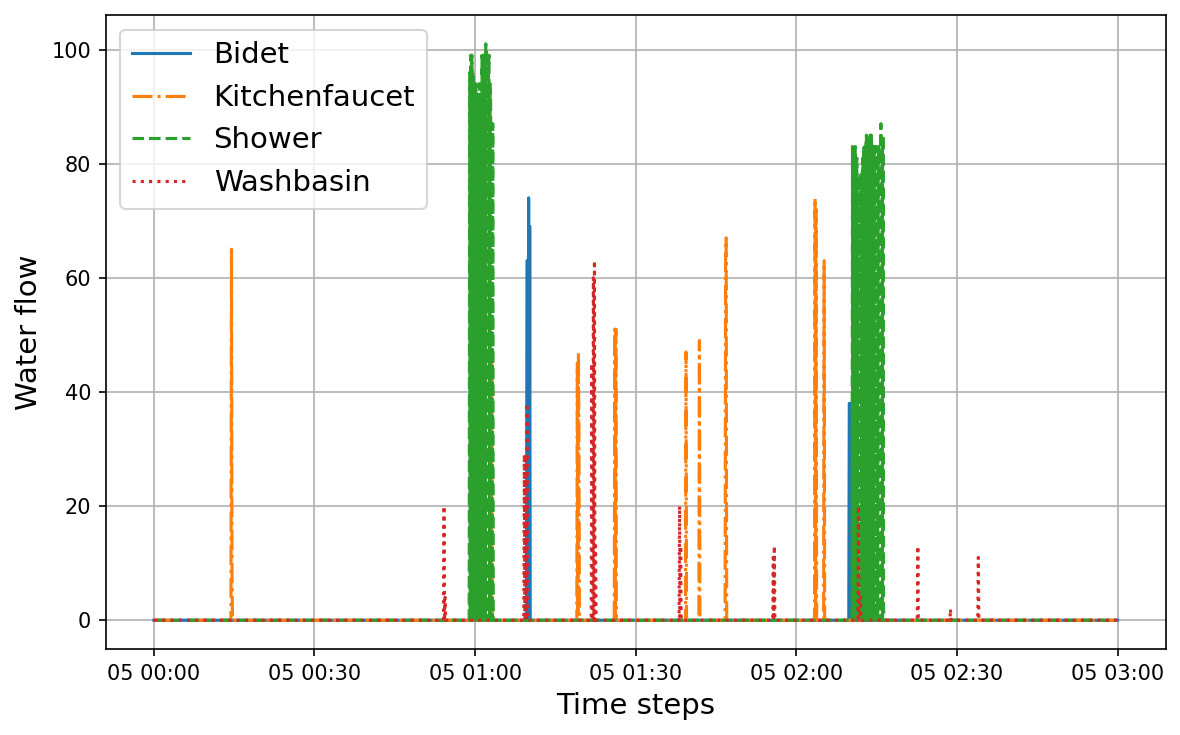

In [111]:
# 描画範囲の指定 (例: 最初の600タイムステップ)
start_time = "2020-08-05 00:00:00"
end_time = "2020-08-05 03:00:00"

# グラフの作成
plt.figure(figsize=(8, 5), dpi=150)  # グラフサイズと解像度を指定

# 各水栓のデータのプロット
plt.plot(data_6s["Flow_bidet"][start_time:end_time], label="Bidet", linestyle="-")
plt.plot(data_6s["Flow_kitchenfaucet"][start_time:end_time], label="Kitchenfaucet", linestyle="-.")
plt.plot(data_6s["Flow_shower"][start_time:end_time], label="Shower", linestyle="--")
plt.plot(data_6s["Flow_washbasin"][start_time:end_time], label="Washbasin", linestyle=":")

# 軸ラベル、タイトル、凡例の追加
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Water flow", fontsize=14)
#plt.title("Water flow of each appliance", fontsize=16) #必要であれば追加
plt.legend(fontsize=14)
plt.grid(True)

# x軸の目盛りを調整 (必要に応じて)
#plt.xticks(rotation=45) #必要であれば追加
#plt.xlim(start_time, end_time) #必要であれば追加

# グラフの表示
plt.tight_layout() #グラフのレイアウト調整
plt.show()

##### その他処理失敗

In [4]:
# UnixTimestampをdatetimeに
for df in dfs:
  for i in range(len(df)):
    df["Time"][i] = pd.Timestamp.fromtimestamp(df["Time"][i])

for df in dfs:
  df.set_index("Time", inplace=True)

# リサンプリング
resampled_dfs_6s = [df.resample('6s').sum() for df in dfs]
resampled_dfs_10s = [df.resample('10s').sum() for df in dfs]
resampled_dfs_1m = [df.resample('1min').sum() for df in dfs]

# 欠損値補完
for df_list in [resampled_dfs_6s, resampled_dfs_10s, resampled_dfs_1m]:
  for df in df_list:
    df.fillna(0, inplace=True)

C:\Users\Ca_on\AppData\Local\Temp\ipykernel_23092\1882765527.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["Time"][i] = pd.Timestamp.fromtimestamp(df["Time"][i])
C:\Users\Ca_on\AppData\Local\Temp\ipykernel_23092\1882765527.py:6: Set

##### 訓練とテストデータ

In [112]:
# データの正規化
for df in [data_6s, data_10s, data_1m]:
  for column in df.columns:
    df[column] = (df[column] - df[column].mean()) / df[column].std()

data_6s

,Flow_bidet,Flow_kitchenfaucet,Flow_shower,Flow_washbasin,Flow_whole
Time,,,,,
2020-08-04 10:13:12,-0.008029,-0.012603,-0.015753,-0.012898,-0.023873
2020-08-04 10:13:18,-0.008029,-0.012603,-0.015753,-0.012898,-0.023873
2020-08-04 10:13:24,-0.008029,-0.012603,-0.015753,-0.012898,-0.023873
2020-08-04 10:13:30,-0.008029,-0.012603,-0.015753,-0.012898,-0.023873
2020-08-04 10:13:36,-0.008029,-0.012603,-0.015753,-0.012898,-0.023873
...,...,...,...,...,...
2020-08-30 20:14:12,-0.008029,-0.012603,-0.015753,-0.012898,-0.023873
2020-08-30 20:14:18,-0.008029,-0.012603,-0.015753,-0.012898,-0.023873
2020-08-30 20:14:24,-0.008029,-0.012603,-0.015753,-0.012898,-0.023873


In [113]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    時系列データを教師あり学習用のデータセットに変換。
    引数:
        data: 観測値のリストまたはNumPy配列。
        n_in: 入力として使用する遅延観測値の数 (X)。
        n_out: 出力として使用する観測値の数 (y)。
        dropnan: NaN値を含む行を削除するかどうかのブール値。
    戻り値:
    教師あり学習用にフレーム化されたPandas DataFrame。
    """
    n_vars = 1 if type(data) is list else data.shape[1]  # データがリストの場合は変数の数を1に、それ以外の場合はデータの列数に設定
    df = pd.DataFrame(data)  # データをPandas DataFrameに変換
    cols, names = list(), list()  # 列と名前のリストを初期化
    # 入力シーケンス (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))  # データをiだけシフトして列に追加
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]  # シフトしたデータの名前をリストに追加
    # 予測シーケンス (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))  # データを-iだけシフトして列に追加
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]  # 現在のデータの名前をリストに追加
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]  # シフトしたデータの名前をリストに追加
    # すべてを一つにまとめる
    agg = pd.concat(cols, axis=1)  # 列を横方向に結合
    agg.columns = names  # 列に名前を設定
    # NaN値を含む行を削除
    if dropnan:
        agg.dropna(inplace=True)  # NaN値を含む行を削除
    return agg  # フレーム化されたデータを返す

In [120]:
# 色々差分を取ってみる
temp = data_6s.iloc[:,4]
temp = temp.to_list()
df = series_to_supervised(temp, n_in=9, n_out=1)
df

,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
9,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873
10,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873
11,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873
12,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873
13,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873
...,...,...,...,...,...,...,...,...,...,...
380410,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873
380411,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873
380412,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873
380413,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873,-0.023873


In [115]:
def calculate_metrics(y_pred, y_true):
    """
    各器具のMAE、EAC、NDEを計算する関数
    結果見るにたぶん間違っているので要修正
    """
    n_samples, n_outputs = y_true.shape
    mae = np.zeros(n_outputs)
    eac = np.zeros(n_outputs)
    nde = np.zeros(n_outputs)

    for i in range(n_outputs):
        mae[i] = mean_absolute_error(y_true[:, i], y_pred[:, i])
        eac[i] = 1 - (np.sum(np.abs(y_pred[:, i] - y_true[:, i])) / (2 * np.sum(y_true[:, i]))) 
        nde[i] = np.sum((y_pred[:, i] - y_true[:, i])**2) / np.sum(y_true[:, i]**2)

    return mae, eac, nde

In [123]:
"""
時系列ととらえるべきではない
"""

X = data_6s.iloc[:,4]
# X = df.iloc[:,:10]
X = X.to_frame()
Y = data_6s.iloc[:,0:4]
# Y = data_6s.iloc[10:,0:4]

test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, shuffle = False, stratify = None)

# 決定木
print(f"-----------------------------------------------------")
print(f"dtの学習開始...")
dt = MultiOutputRegressor(DecisionTreeRegressor(random_state=42), n_jobs=2)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_test_dt = np.array(y_test)

mae, eac, nde = calculate_metrics(y_pred_dt, y_test_dt)

for i, col_name in enumerate(y_test.columns):
        print(f"  {col_name} | MAE: {mae[i]:.4f} | EAC: {eac[i]:.4f} | NDE: {nde[i]:.4f}")
print(f"  平均: | MAE: {np.mean(mae):.4f} | EAC: {np.mean(eac):.4f} | NDE: {np.mean(nde):.4f}")
print(f"-----------------------------------------------------")

# Bagging
print(f"-----------------------------------------------------")
print(f"baggingの学習開始...")
bagging = MultiOutputRegressor(BaggingRegressor(random_state=42), n_jobs=2)
bagging.fit(X_train, y_train)

y_pred_bg = bagging.predict(X_test)
y_test_bg = np.array(y_test)

mae, eac, nde = calculate_metrics(y_pred_bg, y_test_bg)

for i, col_name in enumerate(y_test.columns):
        print(f"  {col_name} | MAE: {mae[i]:.4f} | EAC: {eac[i]:.4f} | NDE: {nde[i]:.4f}")
print(f"  平均: | MAE: {np.mean(mae):.4f} | EAC: {np.mean(eac):.4f} | NDE: {np.mean(nde):.4f}")
print(f"-----------------------------------------------------")

# Randomforest
print(f"-----------------------------------------------------")
print(f"Randomforestの学習開始...")
rf = MultiOutputRegressor(RandomForestRegressor(random_state=42), n_jobs=2)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_test_rf = np.array(y_test)

mae, eac, nde = calculate_metrics(y_pred_rf, y_test_rf)

for i, col_name in enumerate(y_test.columns):
        print(f"  {col_name} | MAE: {mae[i]:.4f} | EAC: {eac[i]:.4f} | NDE: {nde[i]:.4f}")
print(f"  平均: | MAE: {np.mean(mae):.4f} | EAC: {np.mean(eac):.4f} | NDE: {np.mean(nde):.4f}")
print(f"-----------------------------------------------------")

-----------------------------------------------------
dtの学習開始...
  Flow_bidet | MAE: 0.0100 | EAC: 7.7720 | NDE: 0.8207
  Flow_kitchenfaucet | MAE: 0.0109 | EAC: 3.3590 | NDE: 0.7677
  Flow_shower | MAE: 0.0038 | EAC: 1.1277 | NDE: 8.8397
  Flow_washbasin | MAE: 0.0132 | EAC: 4.4705 | NDE: 0.9127
  平均: | MAE: 0.0095 | EAC: 4.1823 | NDE: 2.8352
-----------------------------------------------------
-----------------------------------------------------
baggingの学習開始...
  Flow_bidet | MAE: 0.0098 | EAC: 7.6369 | NDE: 0.8191
  Flow_kitchenfaucet | MAE: 0.0113 | EAC: 3.4379 | NDE: 0.8024
  Flow_shower | MAE: 0.0040 | EAC: 1.1342 | NDE: 9.2095
  Flow_washbasin | MAE: 0.0126 | EAC: 4.2996 | NDE: 0.8328
  平均: | MAE: 0.0094 | EAC: 4.1271 | NDE: 2.9160
-----------------------------------------------------
-----------------------------------------------------
Randomforestの学習開始...
  Flow_bidet | MAE: 0.0100 | EAC: 7.7448 | NDE: 0.7883
  Flow_kitchenfaucet | MAE: 0.0112 | EAC: 3.4117 | NDE: 0.7832
  

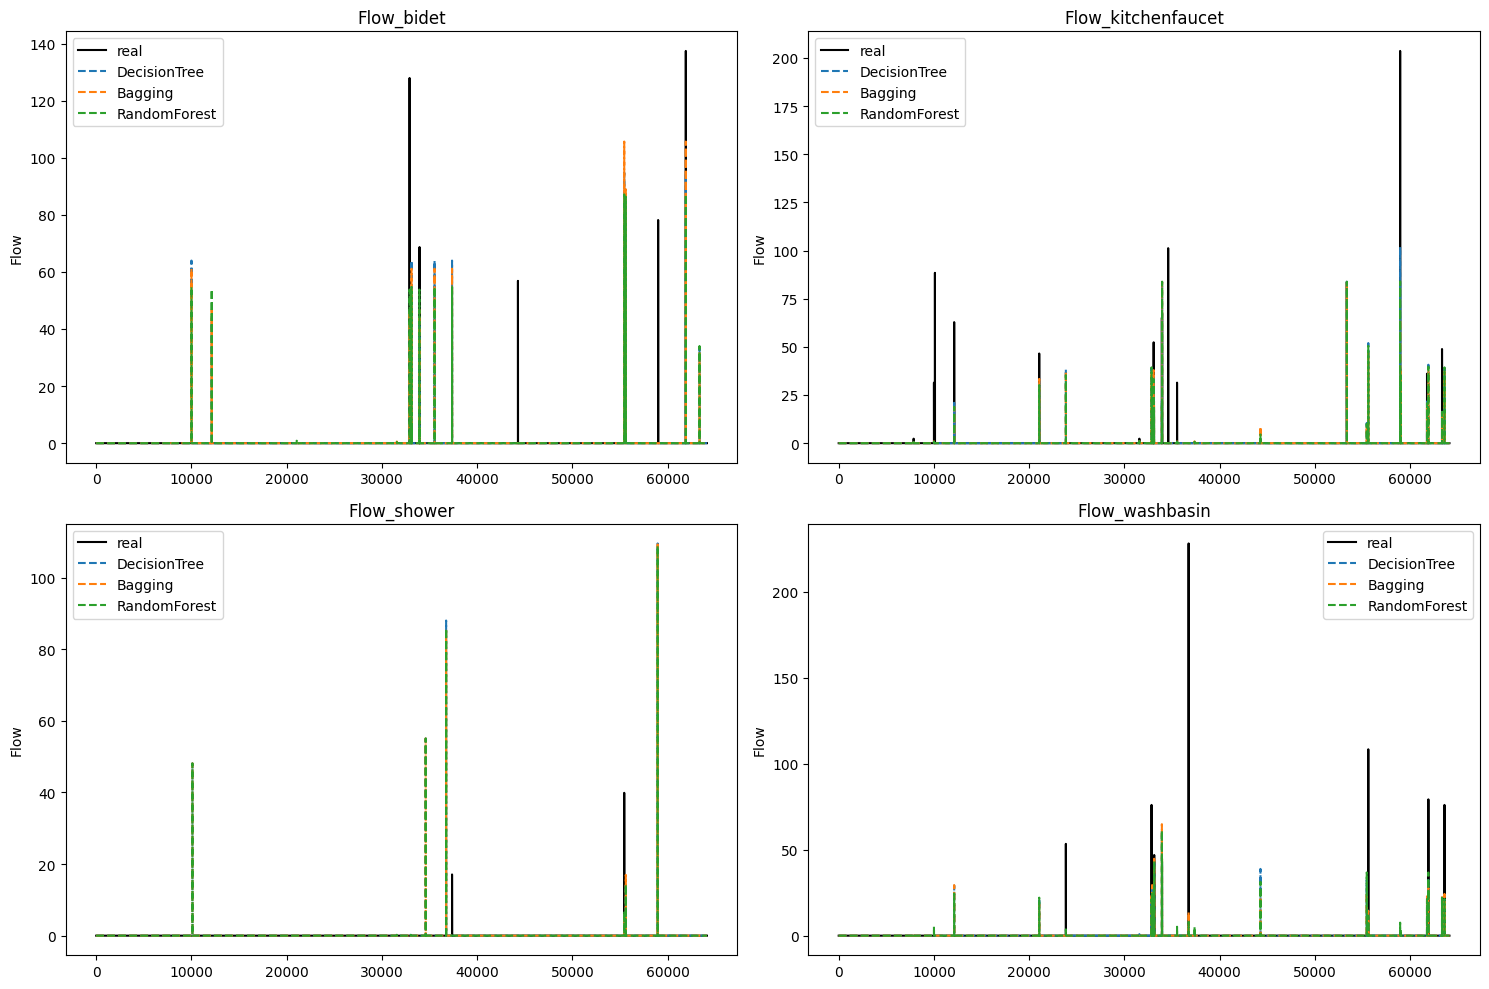

In [87]:
predictions = {
    "DecisionTree": y_pred_dt,
    "Bagging": y_pred_bg,
    "RandomForest": y_pred_rf
}

# 可視化
appliance_names = Y.columns

n_plots = len(appliance_names)
n_cols = 2
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

y_test_plt = np.array(y_test)

for i, appliance_name in enumerate(appliance_names):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    ax.plot(y_test_plt[50000:, i], label="real", color="black")

    for model_name, y_pred in predictions.items():
        ax.plot(y_pred[50000:, i], label=model_name, linestyle="--")

    ax.set_title(appliance_name)
    ax.set_ylabel("Flow")
    ax.legend()

plt.tight_layout()
plt.show()